In [1]:
import ROOT as rt
import sys
import collections
from collections import OrderedDict
import uproot

import os
import scipy
import awkward as ak
import time
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import *

import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.24/06
3.6.8 (default, Nov  2 2021, 13:01:57) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


# Load ntuples

In [2]:
%%time

fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()

# for data_year in ['2022','2023','all']:
for data_year in ['all']:

    # path = "/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/data/raw/"
    # fpath_bkg[data_year] = path + f"data_{data_year}_goodLumi.root"
    if data_year == 'all':path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/'
    else: path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data{data_year}/v14/normalized/'
    if data_year == '2022':fpath['data'+data_year] = path + "DisplacedJet-EXOCSCCluster_Run2022-PromptReco_goodLumi.root"
    elif data_year == '2023':fpath['data'+data_year] = path + "Muon-EXOCSCCluster_Run2023-PromptReco_goodLumi.root"
    elif data_year == 'all':fpath['data'+data_year] = path + "EXOCSCCluster_Run2022_2023_goodLumi.root"

fpath['sig'] = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root'
NEvents = {}

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'].values()[0]
    # NEvents[k] = root_dir['NEvents'].counts()
    print("NEvents",NEvents[k])


dataall /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/EXOCSCCluster_Run2022_2023_goodLumi.root
NEvents 34804216.0
sig /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 57555044.0
CPU times: user 736 ms, sys: 27.2 ms, total: 763 ms
Wall time: 782 ms


# apply selections

In [3]:
%%time

cscRechitClusterPhi = {}
dtRechitClusterPhi = {}
deltaPhi_cluster  = {}
cscRechitClusterDNN  = {}
dtRechitClusterSize  = {}
dtRechitClusterBX  = {}
cscRechitClusterSize = {}
weight = {}
HMTEff = {}

cscRechitClusterEta = {}
cscRechitClusterPhi = {}
dtRechitClusterEta = {}
dtRechitClusterPhi  = {}
evtNum = {}
runNum = {}
            
# categories = ['lowMET','highMET']
categories = ['NStation1', 'NStation2']
categories = ['inclusive']
region_list = ['invertDNN', 'oot', 'signal']
for region in region_list:
    for tree_k in tree.keys():
        T = tree[tree_k]
        
        for cat in categories:
            # if not (met_cat == 'highMET'):continue
            k = f'{region}_{tree_k}_{cat}'
            ########### SELECTION: CLUSTERS ############
            me1 = (T['cscRechitClusterNRechitChamberPlus11'].array()+ T['cscRechitClusterNRechitChamberPlus12'].array()+\
            T['cscRechitClusterNRechitChamberMinus11'].array()+ T['cscRechitClusterNRechitChamberMinus12'].array())
            cscRechitClusterR = (T['cscRechitClusterX'].array()**2+T['cscRechitClusterY'].array()**2)**0.5
            L1 = L1_trg(cscRechitClusterR, np.abs(T['cscRechitClusterZ'].array()), np.abs(T['cscRechitClusterSize'].array()))

            #one cluster to pass trigger
            csccluster = np.logical_and(T['cscRechitClusterTimeWeighted'].array() < 12.5, T['cscRechitClusterTimeWeighted'].array() > -5)
            # csccluster = csccluster & L1
            csccluster = csccluster & (me1 ==0)
            csccluster = csccluster & (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
            csccluster = csccluster & (T['cscRechitClusterJetVetoPt'].array()<30)
            csccluster = csccluster & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    


            dtcluster = (T['dtRechitClusterNHitStation1'].array()==0)
            dtcluster = dtcluster & (T['dtRechitCluster_match_RPChits_dPhi0p5'].array() >= 1)
            dtcluster = dtcluster & (T['dtRechitClusterJetVetoPt'].array()<30)
            dtcluster = dtcluster & np.logical_not((T['dtRechitClusterMuonVetoPt'].array() > 30) & T['dtRechitClusterMuonVetoLooseId'].array())
            # if 'oot' in region: dtcluster = dtcluster & (T['dtRechitCluster_match_RPCBx_dPhi0p5'].array() < 0)
            # else:dtcluster = dtcluster & (T['dtRechitCluster_match_RPCBx_dPhi0p5'].array() == 0)


        ########### SELECTION: EVENTS ############
            sel_ev = T['HLT_CSCDT'].array()
            
            sel_ev = sel_ev & (T['nCscRechitClusters'].array()==1) & (T['nDtRechitClusters'].array()==1)
            sel_ev = np.logical_and(sel_ev ,T['met'].array() < 200)
            if cat == 'NStation1':csccluster = csccluster & (T['cscRechitClusterNStation10'].array() == 1)
            elif cat == 'NStation2':csccluster = csccluster & (T['cscRechitClusterNStation10'].array() > 1)
                
            sel_ev  = sel_ev & (np.sum(dtcluster, axis = 1) == 1)
            sel_ev  = sel_ev & (np.sum(csccluster, axis = 1) == 1)
            print(k, np.count_nonzero(sel_ev))
        ########### BRANCHES ############

           ##### event variables ##### 
            # make sure cluster0 and cluster1 index are different

            cscRechitClusterPhi[k] = T['cscRechitClusterPhi'].array()[csccluster][sel_ev][:,0]
            dtRechitClusterPhi[k] = T['dtRechitClusterPhi'].array()[dtcluster][sel_ev][:,0]
            deltaPhi_cluster[k] = deltaPhi(np.array(cscRechitClusterPhi[k]), np.array(dtRechitClusterPhi[k]))

            cscRechitClusterDNN[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[csccluster][sel_ev][:,0]
            dtRechitClusterBX[k] = T['dtRechitCluster_match_RPCBx_dPhi0p5'].array()[dtcluster][sel_ev][:,0]
            dtRechitClusterSize[k] = T['dtRechitClusterSize'].array()[dtcluster][sel_ev][:,0]
            # cscRechitClusterSize1[k] = T['cscRechitClusterSize'].array()[sel_ev][cluster1][:,0]

            sel = (np.abs(deltaPhi_cluster[k])>0.4)
            
            if 'oot' in region:sel = sel & (cscRechitClusterDNN[k] > 0.96) & (dtRechitClusterBX[k]<0)
            elif 'invertDNN' in region: sel = sel & (cscRechitClusterDNN[k] < 0.96) & (dtRechitClusterBX[k] == 0)
            elif 'signal' in region:sel = sel & (cscRechitClusterDNN[k] > 0.96) & (dtRechitClusterBX[k] == 0)
            else: assert(False)


            print(k, np.count_nonzero(sel))
            deltaPhi_cluster[k] = deltaPhi_cluster[k][sel]
            dtRechitClusterSize[k] = dtRechitClusterSize[k][sel]
            cscRechitClusterSize[k] = T['cscRechitClusterSize'].array()[csccluster][sel_ev][sel][:,0]
            HMTEff[k] = T['cscRechitClusterHMTEfficiency'].array()[csccluster][sel_ev][sel][:,0]
            if 'data' in k:weight[k] = (T['weight'].array())[sel_ev][sel]* 0.0 + 1
            else: weight[k] = (T['pileupWeight'].array()*T['weight'].array())[sel_ev][sel]*HMTEff[k]

            cscRechitClusterEta[k] = T['cscRechitClusterEta'].array()[csccluster][sel_ev][sel][:,0]
            cscRechitClusterPhi[k] = T['cscRechitClusterPhi'].array()[csccluster][sel_ev][sel][:,0]
            dtRechitClusterEta[k] = T['dtRechitClusterEta'].array()[dtcluster][sel_ev][sel][:,0]
            dtRechitClusterPhi[k] = T['dtRechitClusterPhi'].array()[dtcluster][sel_ev][sel][:,0]
            evtNum[k] = T['evtNum'].array()[sel_ev][sel]
            runNum[k] = T['runNum'].array()[sel_ev][sel]

            if np.count_nonzero(sel)<=1:continue
            print("correlation between two variables:", k, scipy.stats.pearsonr(deltaPhi_cluster[k], dtRechitClusterSize[k]))
            print("events in this region:", k, len(deltaPhi_cluster[k]))

invertDNN_dataall_inclusive 35697
invertDNN_dataall_inclusive 2369
correlation between two variables: invertDNN_dataall_inclusive (0.03676085469500499, 0.07363118364573087)
events in this region: invertDNN_dataall_inclusive 2369
invertDNN_sig_inclusive 3642
invertDNN_sig_inclusive 449
correlation between two variables: invertDNN_sig_inclusive (-0.05121949189153124, 0.27880523742564)
events in this region: invertDNN_sig_inclusive 449
oot_dataall_inclusive 35697
oot_dataall_inclusive 1931
correlation between two variables: oot_dataall_inclusive (-0.016381256610437687, 0.47187842766959787)
events in this region: oot_dataall_inclusive 1931
oot_sig_inclusive 3642
oot_sig_inclusive 11
correlation between two variables: oot_sig_inclusive (0.420155470766431, 0.19823360286084804)
events in this region: oot_sig_inclusive 11
signal_dataall_inclusive 35697
signal_dataall_inclusive 1843
correlation between two variables: signal_dataall_inclusive (-0.009712454960157525, 0.6769093097950397)
events in

# check inverted DNN region

0.03244352340698242


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


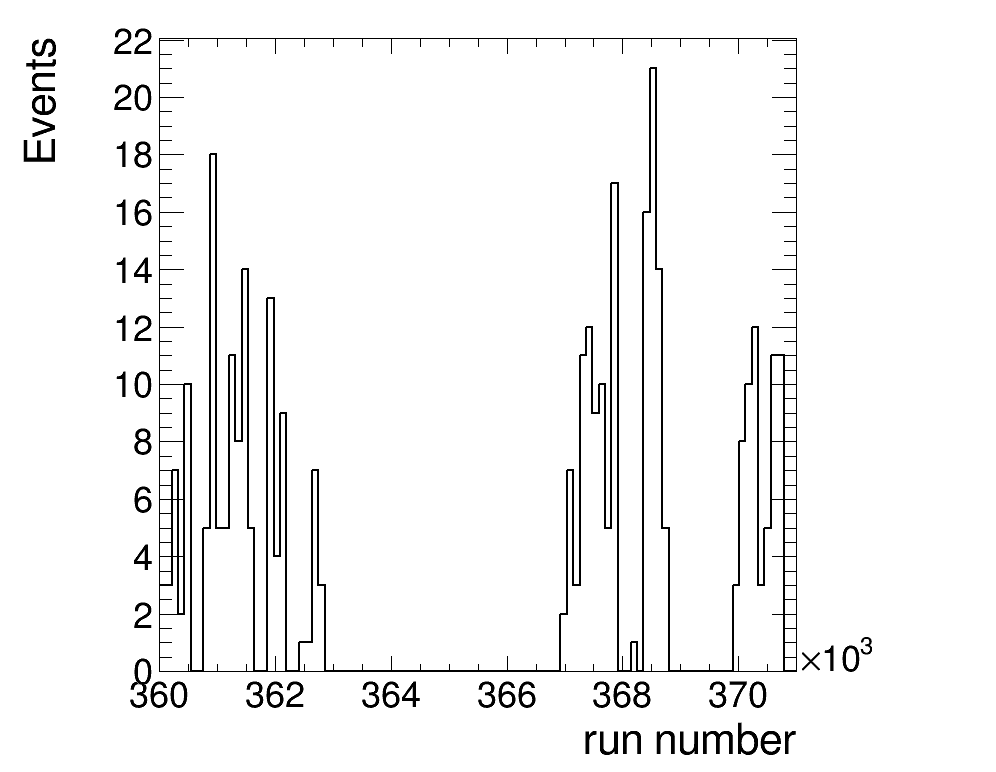

In [22]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
leg = rt.TLegend(0.5,0.7,0.8,0.9)
leg.SetBorderSize(0)
# plot_var = [cscRechitClusterSize1, deltaPhi_cluster]
# axis = ['N_{rechits}','#Delta#phi',]
# name = ['nhits','dphi']
# bins = [[25,50,500],[25,1.8,3.2]]


k = "invertDNN_dataall_inclusive"
h = create_TH2D(np.column_stack(( np.array(cscRechitClusterEta[k]), np.array(cscRechitClusterPhi[k]))),\
               axis_title = ['CSC cluster #eta','CSC cluster #phi','Events'], binning=[100,-3,3,100,-3.2,3.2])
h = create_TH2D(np.column_stack(( np.array(dtRechitClusterEta[k]), np.array(dtRechitClusterPhi[k]))),\
               axis_title = ['DT cluster #eta','DT cluster #phi','Events'], binning=[100,-3,3,100,-3.2,3.2])

h.Draw('colz')

# print(np.min(runNum[k]),np.max(runNum[k]))
h = create_TH1D( np.array(runNum[k][cscRechitClusterSize[k]>160]), axis_title = ['run number','Events'], binning=[100,360000,371000])
h.Draw()
# h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k],k.replace('all',''))

c.SetRightMargin(0.2)

c.Draw()

# c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".png")
# c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".pdf")
# c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".C")




print(time.time()-start_t)

## Create datacard with OOT data for optimization

In [6]:
datacard_version = "v4"

In [22]:
cat = "NStation2"
data_key = f'oot_dataall_{cat}'
signal_key = f'signal_sig_{cat}'
a, b, c, d, pred = {}, {}, {}, {}, {}

outDataCardsDir=f"/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_1_0_pre4/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_run3HMT/dtcsc/OOT_opt/{datacard_version}/"
tree_dir = outDataCardsDir.replace("datacards","limitTrees")
os.system(f"mkdir -p {outDataCardsDir}")
os.system(f"mkdir -p {tree_dir}")

modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"

sig_unc = {'ggH':[[0.2]*4]}
sig_unc_name = ['test']
signal_region = 'a'
prefix = 'csccsc_'

h = {
signal_key: rt.TH2D("","",12,80,200, 12,2.,3.2),
data_key: rt.TH2D("","",12,80,200, 12,2.,3.2),
}

for cscnhit_cut in np.arange(100,300,10):
    if not cscnhit_cut == 160:continue
    for dtnhit_cut in np.arange(80,200,10):
        for dphi_cut in np.arange(2., 3.2, 0.1):
            
            k = signal_key
            for k in [data_key, signal_key]:

                if k == data_key: TF = len(dtRechitClusterSize[data_key.replace("oot","signal")][cscRechitClusterSize[data_key.replace("oot","signal")]>cscnhit_cut])\
                /len(dtRechitClusterSize[data_key][cscRechitClusterSize[data_key]>cscnhit_cut])
                else: TF = 1
                cond = cscRechitClusterSize[k]>cscnhit_cut
                
                a[k] = np.sum(weight[k][cond & (dtRechitClusterSize[k]>=dtnhit_cut) &  (np.abs(deltaPhi_cluster[k])>=dphi_cut)]) * TF
                b[k] = np.sum(weight[k][cond & (dtRechitClusterSize[k]>=dtnhit_cut) &  (np.abs(deltaPhi_cluster[k])<dphi_cut)]) * TF
                c[k] = np.sum(weight[k][cond & (dtRechitClusterSize[k]<dtnhit_cut) &  (np.abs(deltaPhi_cluster[k])<dphi_cut)]) * TF
                d[k] = np.sum(weight[k][cond & (dtRechitClusterSize[k]<dtnhit_cut) &  (np.abs(deltaPhi_cluster[k])>=dphi_cut)]) * TF
                if c[k] == 0: pred[k] = 999
                else: pred[k] = b[k]*d[k]/c[k]
                if k == data_key:
                    if b[k] < 1 or c[k] < 1 or d[k] < 1:continue
                    unc_pred = (TF/c[k] + TF/b[k] + TF/d[k])**0.5*pred[k]
                    # print(k,unc_pred,pred[k],a[k],b[k],c[k],d[k])
            if b[data_key] < 1 or c[data_key] < 1 or d[data_key] < 1:continue
            # print(nhit_cut, dphi_cut, a[signal_key], pred[data_key], a[signal_key]/pred[data_key], unc_pred, pred[data_key])


            xbin = h[data_key].GetXaxis().FindBin(dtnhit_cut)
            ybin = h[data_key].GetYaxis().FindBin(dphi_cut)
            h[data_key].SetBinContent(xbin,ybin,pred[data_key])
            h[signal_key].SetBinContent(xbin,ybin,a[signal_key])

            card_name = f'cscnhits{cscnhit_cut}_dtnhits{dtnhit_cut}_dphi'+str(round(dphi_cut,1)).replace(".","p") + f'_{cat}'

            ## create datacards ##
            # make_datacard_2tag(
            # outDataCardsDir,
            # card_name,
            # {'ggH':[a[signal_key],b[signal_key],c[signal_key],d[signal_key]]}, #signal rate
            # a[signal_key], 
            # [pred[data_key],b[data_key],c[data_key],d[data_key]], #bkg rate
            # [a[data_key],b[data_key],c[data_key],d[data_key]], #observation
            # [unc_pred/pred[data_key]], 
            # ['syst'], 
            # sig_unc, 
            # sig_unc_name,
            # signal_region, 
            # prefix
            # )
        
        # break

In [23]:
print(len(dtRechitClusterSize['signal_dataall_NStation1'])/len(dtRechitClusterSize['oot_dataall_NStation1']))
print(len(dtRechitClusterSize['signal_dataall_NStation2'])/len(dtRechitClusterSize['oot_dataall_NStation2']))

0.9221590909090909
1.286549707602339


# plot signal/bkg

Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/oot_dataall_NStation2_dtcsc.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/oot_dataall_NStation2_dtcsc.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/oot_dataall_NStation2_dtcsc.C has been generated


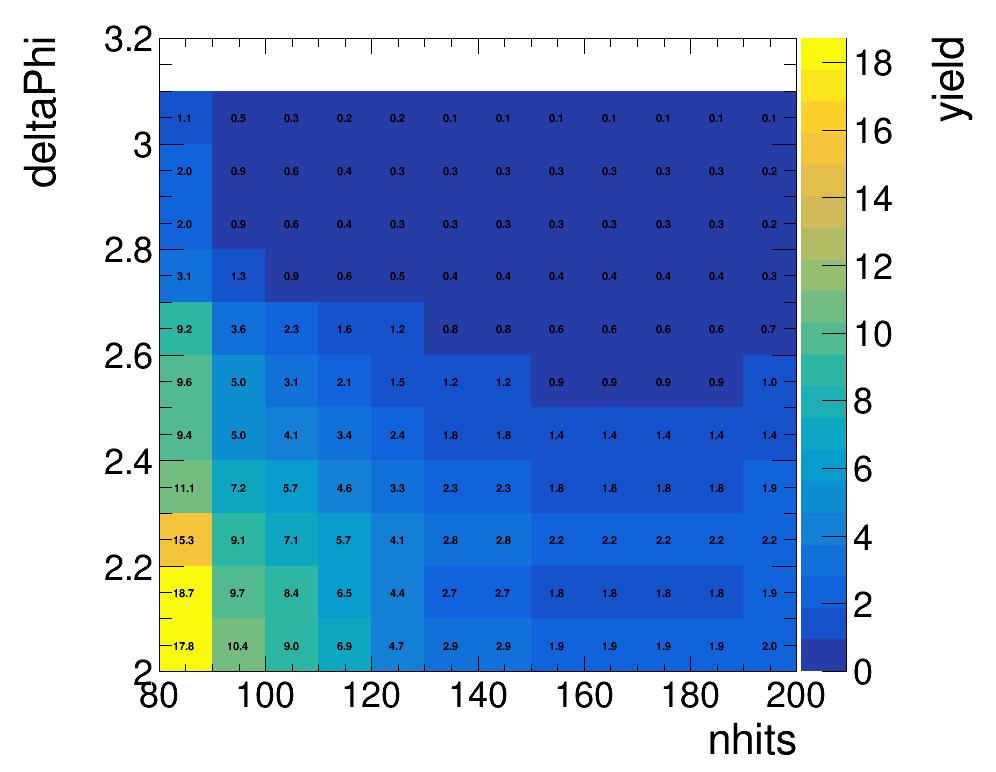

In [24]:
rt.gStyle.SetPaintTextFormat("1.1f");
c = rt.TCanvas('c','c', 1000, 800)

k = signal_key
k = data_key
h[k].GetXaxis().SetTitle("nhits")
h[k].GetYaxis().SetTitle("deltaPhi")
h[k].GetZaxis().SetTitle("yield")
h[k].GetZaxis().SetTitleOffset(1.1)

h[k].SetMarkerSize(0.8)

h[k].Draw("colz text")
c.SetRightMargin(0.2)
c.Draw()

c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/"+k+"_dtcsc.png")
c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/"+k+"_dtcsc.pdf")
c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/"+k+"_dtcsc.C")


## Plot combine result

In [18]:
datacard_version = "v4"
outDataCardsDir=f"/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_1_0_pre4/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_run3HMT/dtcsc/OOT_opt/{datacard_version}/"
tree_dir = outDataCardsDir.replace("datacards","limitTrees")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/limit_dtcsc_cscnhit160_NStation2.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/limit_dtcsc_cscnhit160_NStation2.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/limit_dtcsc_cscnhit160_NStation2.C has been generated


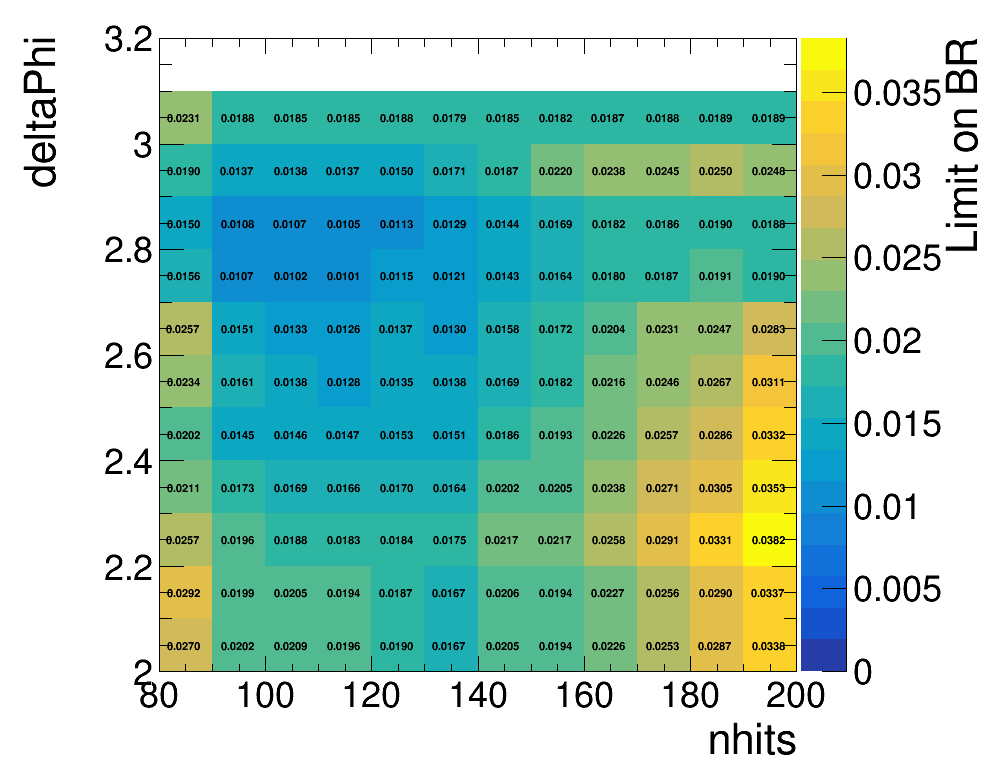

In [26]:
rt.gStyle.SetPaintTextFormat("1.4f");

c = rt.TCanvas('c','c', 1000, 800)
# h_opt = rt.TH2D("","",22,80,300, 22,1.0,3.2)
for cat in categories:
    if not cat == 'NStation2':continue
    for cscnhit_cut in np.arange(100,300,10):
        if not cscnhit_cut == 160:continue
        h_opt = rt.TH2D("","",12,80,200, 12,2.0,3.2)

        for nhit_cut in np.arange(80,200,10):
            for dphi_cut in np.arange(2., 3.2, 0.1):


                ###### open datacard and limit ######
                card_name = f"cscnhits{cscnhit_cut}_dtnhits{nhit_cut}_dphi"+str(round(dphi_cut,1)).replace(".","p") + f'_{cat}'
                if not os.path.isfile(f"{outDataCardsDir}/{card_name}.txt"):continue
                signal_norm = readNorm(f"{outDataCardsDir}/{card_name}.txt")

                tree_name = f"higgsCombine.{card_name}.AsymptoticLimits.mH120.root"
                limitTree = tree_dir + '/' + tree_name
                if not os.path.isfile(limitTree):continue
                if len(uproot.open(limitTree).keys()) == 2:
                        T = uproot.open(limitTree)['limit']                
                        if len(np.array(T['limit'].array())>0):limit = np.array(T['limit'].array())/signal_norm


                xbin = h_opt.GetXaxis().FindBin(nhit_cut)
                ybin = h_opt.GetYaxis().FindBin(dphi_cut)
                h_opt.SetBinContent(xbin,ybin,limit[2])
                # if limit[2]<0.008: print(nhit_cut, dphi_cut, limit[2], h[data_key].GetBinContent(xbin,ybin), h[signal_key].GetBinContent(xbin,ybin))

        h_opt.SetMarkerSize(0.8)
        h_opt.GetXaxis().SetTitle("nhits")
        h_opt.GetYaxis().SetTitle("deltaPhi")
        h_opt.GetZaxis().SetTitle("Limit on BR")
        h_opt.GetZaxis().SetTitleOffset(1.2)
        h_opt.Draw("colz text")
        c.SetRightMargin(0.2)
        c.Draw()

        c.SaveAs(f"/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/limit_dtcsc_cscnhit{cscnhit_cut}_{cat}.png")
        c.SaveAs(f"/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/limit_dtcsc_cscnhit{cscnhit_cut}_{cat}.pdf")
        c.SaveAs(f"/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/OOT_opt/limit_dtcsc_cscnhit{cscnhit_cut}_{cat}.C")
